In [1]:
!pip install zarr xarray s3fs matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 20.7 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=86e623d3c44d418843cf8766c8cdf3ed4e9a4a66794a57ad70ddf1b7c1f9359c
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [2]:
import zarr
import s3fs
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors

In [3]:
shot_id = 30462
endpoint_url = 'https://s3.echo.stfc.ac.uk'
url = f's3://mast/level2/shots/{shot_id}.zarr'

fs = fsspec.filesystem(
  **dict(
    protocol='simplecache',
    target_protocol="s3",
    target_options=dict(anon=True, endpoint_url=endpoint_url)
  )
)

store = zarr.storage.FSStore(fs=fs, url=url)

### Useful Signals

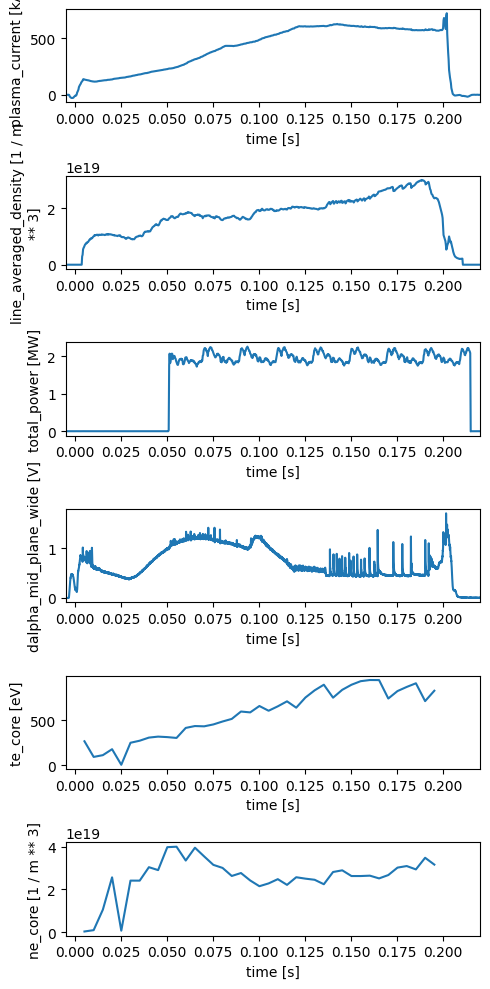

In [4]:
profiles = xr.open_zarr(store, group='summary')

fig, axes = plt.subplots(6, 1, figsize=(5, 10))
profiles.plasma_current.plot(ax=axes[0])
profiles.line_averaged_density.plot(ax=axes[1])
profiles.total_power.plot(ax=axes[2])

dalphas = xr.open_zarr(store, group='dalpha')
dalphas.dalpha_mid_plane_wide.plot(ax=axes[3])

ts = xr.open_zarr(store, group='thomson_scattering')
ts.te_core.plot(ax=axes[4])
ts.ne_core.plot(ax=axes[5])

for ax in axes:
  ax.set_xlim(-0.005, 0.22)
plt.tight_layout()

In [11]:
profiles

<xarray.Dataset> Size: 536kB
Dimensions:                  (time: 16750)
Coordinates:
  * time                     (time) float64 134kB -0.0598 -0.05978 ... 0.2752
Data variables:
    dalpha_mid_plane_center  (time) float64 134kB dask.array<chunksize=(16750,), meta=np.ndarray>
    dalpha_mid_plane_wide    (time) float64 134kB dask.array<chunksize=(16750,), meta=np.ndarray>
    dalpha_tangential        (time) float64 134kB dask.array<chunksize=(16750,), meta=np.ndarray>

### D-alpha

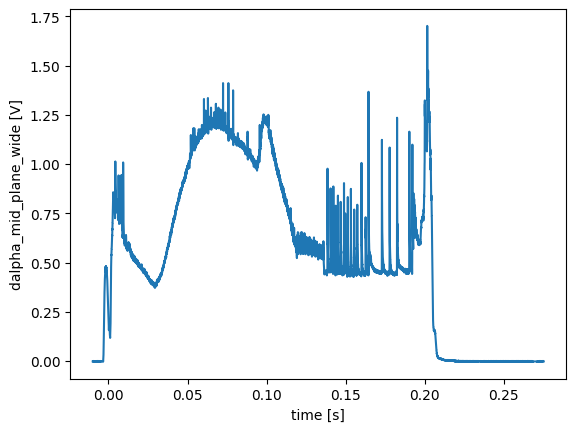

In [5]:
profiles = xr.open_zarr(store, group='dalpha')

profiles.dalpha_mid_plane_wide.plot()

0.0
90.3
detected, too recurrent, too short, too long
18 5 2 0


Text(0.5, 0.98, 'Shot #30462')

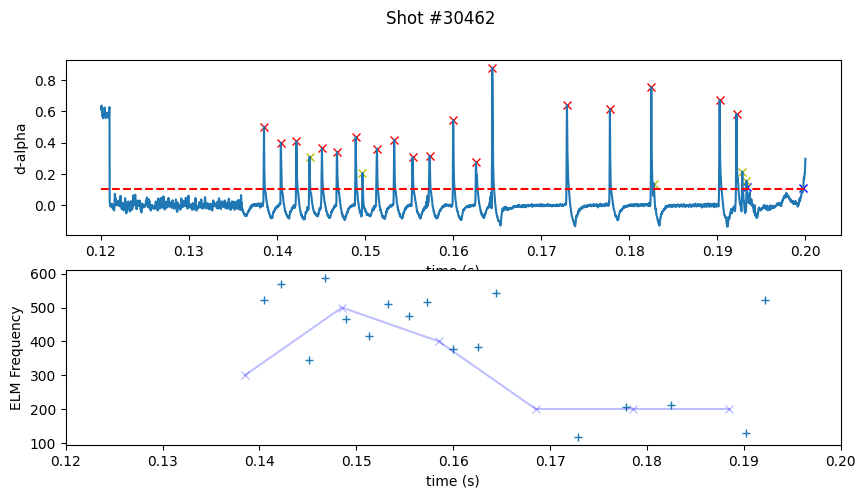

In [10]:
def identify_bursts(series,thresh,analyse=True):
  # a handy function from Nick Walkdens time series tools. Thanks Nick!

  inds_above_thresh = np.where(series>thresh)
  inds_below_thresh = np.where(series<=thresh)
  windows = []
  leng = len(inds_above_thresh[0])+0.0
  for i, ind in enumerate(inds_above_thresh[0]):
      if i%250==0:
        perc_done = (i/leng)*100
        print('%0.1f'%perc_done)
      try:
          #Extract highest possible index that occurs before a filement,
          ind_low = np.extract(inds_below_thresh < ind,inds_below_thresh)[-1]
          #Extract lowest possible index that occurs after a filemant
          ind_up = np.extract(inds_below_thresh > ind,inds_below_thresh)[0]
          if (ind_low,ind_up) not in windows:
              #Make sure that there is no double counting
              windows.append((ind_low,ind_up))
      except:
          pass
  if analyse:
      N_bursts = len(windows)
      burst_ratio = len(list(series))/N_bursts
      av_window = np.mean([y - x for x,y in windows])
      return windows,N_bursts,burst_ratio,av_window
  else:
      return windows

def background_subtract(dalpha: xr.DataArray) -> xr.DataArray:
  dtime = dalpha.time.values
  values = dalpha.values
  dt = dtime[1]-dtime[0]
  n = int(moving_av_length/dt)
  ret = np.cumsum(values, dtype=float)
  ret[n:] = ret[n:] - ret[:-n]
  ret = ret[n - 1:] / n
  values[n - 1:]-=ret
  dalpha.values = values
  return dalpha

def filter_windows(windows, dalpha, dtime):
  too_short_windows = []
  too_long_windows = []

  num_too_short=0
  num_too_long=0

  # filter spikes too short to be elms
  for i in range(len(windows)):
    if (dtime[windows[i][1]]-dtime[windows[i][0]])<min_elm_duration:
      too_short_windows.append(windows[i])
      windows[i]=(0,0)
      num_too_short+=1
    if (dtime[windows[i][1]]-dtime[windows[i][0]])>max_elm_duration:
      too_long_windows.append(windows[i])
      windows[i]=(0,0)
      num_too_long+=1

  windows = [x for x in windows if x!=(0,0)]

  too_short_inds = [np.argmax(dalpha[too_short_windows[x][0]:too_short_windows[x][1]]) + too_short_windows[x][0] for x in range(len(too_short_windows))]
  too_long_inds = [np.argmax(dalpha[too_long_windows[x][0]:too_long_windows[x][1]]) + too_long_windows[x][0] for x in range(len(too_long_windows))]

  too_short = dalpha[too_short_inds]
  too_short_t = dtime[too_short_inds]

  too_long = dalpha[too_long_inds]
  too_long_t = dtime[too_long_inds]

  elm_inds = [np.argmax(dalpha[windows[x][0]:windows[x][1]]) + windows[x][0] for x in range(len(windows))]
  elm_heights = dalpha[elm_inds]
  elm_times = dtime[elm_inds]


  too_recurrent=0
  freq_filtered_inds = np.zeros(0,dtype=int)

  for i in range(len(elm_inds)-1):
    if elm_heights[i]!=0 and i not in freq_filtered_inds:
      close_inds = np.where(elm_times[i+1:]-elm_times[i]<min_elm_seperation)[0]+i+1
      freq_filtered_inds=np.concatenate((freq_filtered_inds,close_inds))

  freq_filtered_inds = np.unique(freq_filtered_inds)
  too_recurrent = len(freq_filtered_inds)
  freq_filtered_t = elm_times[freq_filtered_inds]
  freq_filtered = elm_heights[freq_filtered_inds]

  elm_times[freq_filtered_inds]=0
  elm_heights[freq_filtered_inds]=0

  elm_times=elm_times[np.where(elm_heights!=0)]
  elm_heights=elm_heights[np.where(elm_heights!=0)]

  num_elms = len(elm_heights)

  print('detected, too recurrent, too short, too long')
  print(num_elms, too_recurrent, num_too_short, num_too_long)
  return elm_times, elm_heights, too_short, too_short_t, too_long, too_long_t, freq_filtered, freq_filtered_t


def calculate_elm_frequency(elm_times):
  freq_t = np.arange(min(elm_times),max(elm_times),elm_interval)
  freq = np.zeros(len(freq_t))

  for index, time in enumerate(freq_t):
    num = len(np.where((elm_times>time-elm_interval/2)&(elm_times<time+elm_interval/2))[0])
    freq[index] = num/elm_interval

  return freq_t, freq

# ELM Detection Parameters
threshold = 0.1
moving_av_length = 0.001
min_elm_duration = 0.05 * 1e-3
max_elm_duration = 50 * 1e-3
min_elm_seperation = 1.5 * 1e-3
tmin, tmax = 0.12, 0.2
elm_interval = 0.01

# D-alpha signal
dalpha = profiles.dalpha_mid_plane_wide.copy()

# Preprocessing dalpha signal
dalpha = dalpha.dropna(dim='time')
dalpha = dalpha.sel(time=slice(tmin,tmax))
dalpha = background_subtract(dalpha)

# ELM Identification
windows = identify_bursts(dalpha.values, threshold, analyse=False)
elm_times, elm_heights, too_short, too_short_t, too_long, too_long_t, freq_filtered, freq_filtered_t = filter_windows(windows, dalpha.values, dalpha.time.values)
freq_t, freq = calculate_elm_frequency(elm_times)

# Plot results

# ELMS

fig, axes = plt.subplots(2, 1, figsize=(10,5))
ax = axes[0]
ax.plot(elm_times, elm_heights, 'xr')
ax.plot(too_short_t, too_short, 'xb')
ax.plot(freq_filtered_t, freq_filtered, 'xy')
ax.plot(too_long_t, too_long, 'xg')
ax.plot(dalpha.time, dalpha)
ax.hlines(threshold, tmin, tmax, linestyles='--', color='r')
ax.set_ylabel('d-alpha')
ax.set_xlabel('time (s)')

# ELM Frequency
ax = axes[1]
ax.plot(elm_times[1:],1/(elm_times[1:]-elm_times[:-1]),'+')
ax.plot(freq_t,freq,'-xb',alpha=0.25)
ax.set_xlim([tmin, tmax])
ax.set_ylabel('ELM Frequency')
ax.set_xlabel('time (s)')

plt.suptitle(f'Shot #{shot_id}')